# Temporal Analysis per ROI

## Description

This algorithm does the following:

1) extracts data from a given coordinate location (lon, lat)
2) applyes a temporal detrending analysis over the time-series
3) fit a temporal model over the time-series 


This algorithm was derived from [here](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api)
and [here](https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861)




In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import ee

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Sx8haaNksamSJQc5abMXWeW8cRo3ZFNRtDhhbpJVSTg&tc=_EyuzXPKwtvpYS5O5yVs9uuMo15WrNaPesDEynVmUbs&cc=6LdPEonaJA_pXhz6jXeag4dyLiIOvToDl7Y9MmD_iC4

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AdQt8qg14Bs0p-a7_ZVrzjjnLcT36FFaur1WyoiwoDaC83UkeBIoDHxzebo

Successfully saved authorization token.


# Defining some helper functions

In [3]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

In [4]:
# Define the urban location of interest as a point near Lyon, France.
def definePoint(lon= 4.8148, lat= 45.7758):
  point = ee.Geometry.Point(lon, lat)
  return point

u_point = definePoint()

# Define the rural location of interest as a point away from the city.

r_point = definePoint(5.175964, 45.574064)

In [5]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(u_point, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_point, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_point, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

Ground elevation at urban point: 196 m
Average daytime LST at urban point: 22.03 °C
Land cover value at urban point is: 13


In [6]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_point = lst.getRegion(u_point, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_point = lst.getRegion(r_point, scale).getInfo()

# Preview the result.
for info in lst_u_point[:5]:
  print(info)

['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day', 'Day_view_time', 'Day_view_angle', 'LST_Night_1km', 'QC_Night', 'Night_view_time', 'Night_view_angle', 'Emis_31', 'Emis_32', 'Clear_day_cov', 'Clear_night_cov']
['2000_02_24', 4.810478346460038, 45.77365530231022, 951350400000, None, 2, None, None, None, 2, None, None, None, None, None, None]
['2000_02_25', 4.810478346460038, 45.77365530231022, 951436800000, None, 2, None, None, 13596, 81, 224, 84, 240, 243, None, 1059]
['2000_02_26', 4.810478346460038, 45.77365530231022, 951523200000, 14365, 145, 120, 115, 13990, 81, 215, 10, 240, 243, 2000, 4000]
['2000_02_27', 4.810478346460038, 45.77365530231022, 951609600000, 14391, 81, 110, 38, 14081, 81, 222, 64, 240, 243, 1967, 2000]


In [ ]:
def ee_array_to_df(arr, list_of_bands=None):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Keep the columns of interest.
    if list_of_bands:
      df = df[['longitude', 'latitude', 'time', *list_of_bands]]

    # Remove rows without data inside.
    df = df.dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
      df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    return df

In [ ]:
def getDataFromPoint(roi,
                     imageCollection,
                     scale= 1000,  # scale in meters
                     list_of_bands=None):

  eeArray = imageCollection.getRegion(roi, scale).getInfo()
  df = ee_array_to_df(eeArray, list_of_bands)

  return df

In [ ]:

lst_df_urban = getDataFromPoint(u_point,
                                imageCollection = lst,
                                scale= 1000,  # scale in meters
                                list_of_bands=['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)
lst_df_urban["areaType"] = "Urban"
# Do the same for the rural point.
lst_df_rural = getDataFromPoint(r_point,
                                imageCollection = lst,
                                scale= 1000,  # scale in meters
                                list_of_bands=['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_rural["areaType"] = "Rural"
lst_df_urban.head()

Full_df = pd.concat([lst_df_urban, lst_df_rural], axis=0)

In [ ]:
Full_df.dtypes

0
longitude              object
latitude               object
time                   object
LST_Day_1km           float64
datetime       datetime64[ns]
areaType               object
dtype: object

In [ ]:
Full_df.head(30)

,longitude,latitude,time,LST_Day_1km,datetime,areaType
2,4.810478,45.773655,951523200000,14.15,2000-02-26,Urban
3,4.810478,45.773655,951609600000,14.67,2000-02-27,Urban
4,4.810478,45.773655,951696000000,16.17,2000-02-28,Urban
9,4.810478,45.773655,952128000000,7.11,2000-03-04,Urban
10,4.810478,45.773655,952214400000,12.49,2000-03-05,Urban
11,4.810478,45.773655,952300800000,12.81,2000-03-06,Urban
12,4.810478,45.773655,952387200000,16.91,2000-03-07,Urban
13,4.810478,45.773655,952473600000,16.55,2000-03-08,Urban
14,4.810478,45.773655,952560000000,20.11,2000-03-09,Urban
16,4.810478,45.773655,952732800000,19.29,2000-03-11,Urban


# Temporal Components analysis

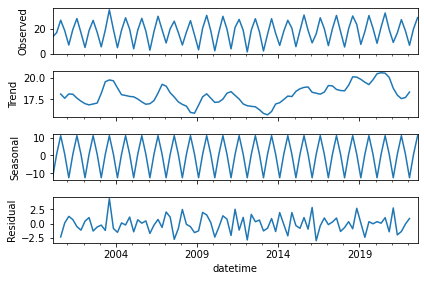

In [ ]:


analysis = (Full_df.loc[Full_df["areaType"]=="Rural"]
           .groupby(pd.Grouper(key="datetime", freq="3M")).mean()
           )

analysis = analysis['LST_Day_1km'].copy()


decompose_result_mult = seasonal_decompose(analysis, model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();
plt.show()

Time-Series Regression Analysis

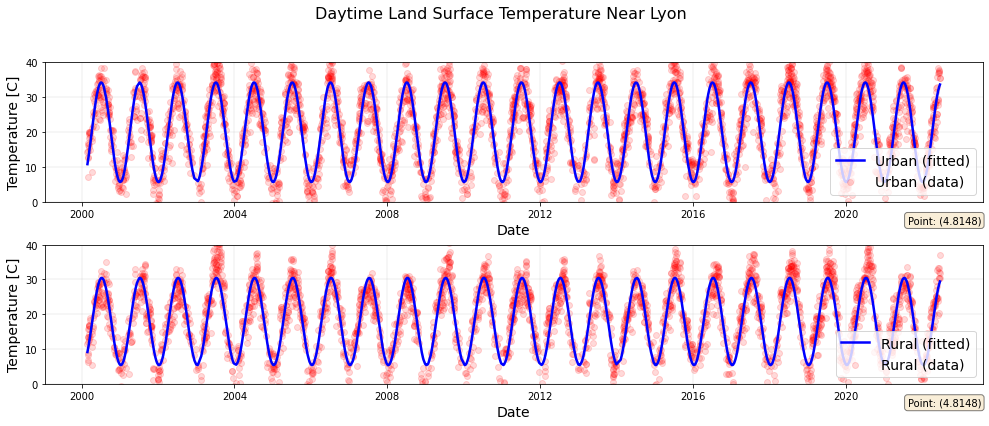

In [ ]:


# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(2,1, figsize=(14, 6))
ax = ax.ravel()
# Add urban (scatter and fitting curve) plots.
ax[0].scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='red', alpha=0.15, label='Urban (data)')
ax[0].plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='blue', lw=2.5)

# Add rural (scatter and fitting curve) plots.

ax[1].scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
              c='red', alpha=0.15, label='Rural (data)')
ax[1].plot(lst_df_rural['datetime'],
           fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
           label='Rural (fitted)', color='blue', lw=2.5)

# Add some parameters.
fig.suptitle('Daytime Land Surface Temperature Near Lyon', fontsize=16)

# Adding a text Box with each Point Information:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)



for axes, point in zip(ax, [u_point, r_point]):
  # place a text box in lower right position (with respect to axes coords)
  textstr = "Point: ({0})".format(u_point.coordinates().getInfo()[0])
  axes.text(0.92, -0.1, textstr, transform=axes.transAxes, fontsize=10,
          verticalalignment='top', bbox=props)
  axes.set_xlabel('Date', fontsize=14)
  axes.set_ylabel('Temperature [C]', fontsize=14)
  axes.set_ylim(-0, 40)
  axes.grid(lw=0.2)
  axes.legend(fontsize=14, loc='lower right')

plt.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()